# Reproduce Paper Figures

This notebook produces all figures used in the [stingray paper](https://github.com/StingraySoftware/stingraypaper).

In [1]:
import altair as alt
alt.renderers.enable("notebook")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_palette('colorblind')

import numpy as np
import pandas as pd

from stingray import sampledata

from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum
from stingray import Crossspectrum, AveragedCrossspectrum

from stingray.modeling import PSDPosterior, PSDParEst

/Users/danielahuppenkothen/work/sw/miniconda3/lib/python3.6/site-packages/stingray-0.1rc1-py3.6.egg/stingray/utils.py:21: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


Let's load some data:

In [2]:
from astropy.io import fits

In [3]:
hdulist = fits.open("../data/GX339-4_eventlist.fits")

In [4]:
data = hdulist[1].data

In [5]:
time = data.field("TIME")
channel = data.field("CHANNEL")
pcuid = hdulist[1].data.field("PCUID")

Which PCUs does this use?

In [6]:
np.min(pcuid)

0

In [7]:
np.max(pcuid)

4

#### Converting channels to energies

Let's convert the channels to energies. This is a bit complicated, but we'll get there.
First, let's read in the channel-to-energy conversion table.



In [8]:
energ_conv = pd.read_csv("../data/rxte_channel_energy.txt", skiprows=25, sep="\t", 
                         names=["channel", "std2", "emax1", "emax2", 
                                "emax3", "emax4", "emax_pcu0", "emax_pcu1234"])

In [9]:
energ_conv.head()

,channel,std2,emax1,emax2,emax3,emax4,emax_pcu0,emax_pcu1234
0,0-4,0,1.51,1.61,1.94,2.13,1.95,2.06
1,5,1,1.76,1.91,2.29,2.54,2.38,2.47
2,6,2,2.02,2.22,2.64,2.96,2.81,2.87
3,7,3,2.27,2.52,2.99,3.37,3.24,3.28
4,8,4,2.53,2.83,3.35,3.79,3.67,3.68


So, this has the conversion for calibration periods 1-5. In calibration period 5, the most recent one, PCU0 lost its propane layer, so the energy boundaries are differnt. We're going to have to redefine some fields here.

Ok, cool. Now we need to convert the maximum energies into mid-bin energies.

In [10]:
emax_pcu0 = np.hstack([[0], np.array(energ_conv["emax_pcu0"])])
emax_pcu1234 = np.hstack([[0], np.array(energ_conv["emax_pcu1234"])])

In [11]:
emid_pcu0 = emax_pcu0[:-1] + np.diff(emax_pcu0)/2.
emid_pcu1234 = emax_pcu1234[:-1] + np.diff(emax_pcu1234)/2.

In [12]:
energ_conv["emid_pcu0"] = emid_pcu0
energ_conv["emid_pcu1234"] = emid_pcu1234

Now we need to split out the energy bins that have more than one channel:

In [13]:
import copy

In [14]:
idx = energ_conv.index

for i in idx:
    #print(i)
    eline = energ_conv.loc[i]
    c = eline["channel"]
    if isinstance(c, str):
        if "-" in c:
            #print(c)
            csplit = c.split("-")
            min_channel = int(csplit[0])
            max_channel = int(csplit[0][:-len(csplit[1])] + csplit[1])
            #print("min_channel: " + str(min_channel))
            #print("max_channel: " + str(max_channel))
            for cc in range(min_channel, max_channel+1, 1):
                #print("cc: " + str(cc))
                e = energ_conv.loc[i].to_dict()
                e["channel"] = int(cc)
                e = pd.DataFrame(e, index=[1000])
                energ_conv = energ_conv.append(e)
            energ_conv = energ_conv.drop(axis=0, index=i)
        else:
            energ_conv.loc[i, "channel"] = np.int(c)



In [15]:
energ_conv = energ_conv.sort_values("channel")

In [16]:
energ_conv = energ_conv.reset_index(drop=True)

In [17]:
energ_conv.head()

,channel,std2,emax1,emax2,emax3,emax4,emax_pcu0,emax_pcu1234,emid_pcu0,emid_pcu1234
0,0,0,1.51,1.61,1.94,2.13,1.95,2.06,0.975,1.03
1,1,0,1.51,1.61,1.94,2.13,1.95,2.06,0.975,1.03
2,2,0,1.51,1.61,1.94,2.13,1.95,2.06,0.975,1.03
3,3,0,1.51,1.61,1.94,2.13,1.95,2.06,0.975,1.03
4,4,0,1.51,1.61,1.94,2.13,1.95,2.06,0.975,1.03


Ok, cool. Now we can try to convert the channels:

In [18]:
emid_pcu0 = pd.Series(energ_conv["emid_pcu0"], index=energ_conv["channel"])
emid_pcu1234 = pd.Series(energ_conv["emid_pcu1234"], index=energ_conv["channel"])

In [19]:
pcu0_mask = (pcuid == 0)

In [20]:
np.sum(pcu0_mask)

2198007

In [21]:
energies = np.zeros(len(channel))

In [22]:
energies[pcu0_mask] = emid_pcu0.loc[channel[pcu0_mask]]

In [23]:
energies[~pcu0_mask] = emid_pcu1234.loc[channel[~pcu0_mask]]

In [24]:
energies

array([1.03, 4.31, 4.29, ..., 2.67, 1.03, 1.03])

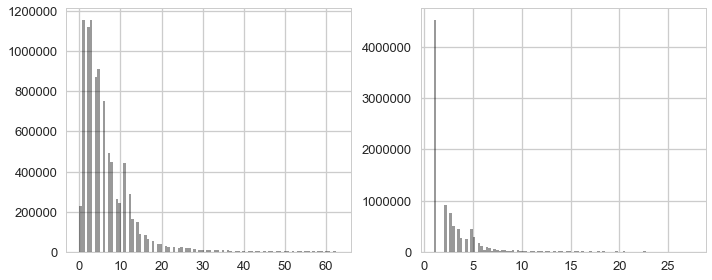

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.hist(channel, bins=100, histtype="stepfilled", alpha=0.4, color="black")
ax2.hist(energies, bins=100, histtype="stepfilled", alpha=0.4, color="black");

plt.tight_layout()

In [26]:
np.sum((channel <= 4))/len(channel)

0.48504964995037464

In [27]:
gti_start = hdulist[2].data.field("Start")
gti_stop = hdulist[2].data.field("Stop")

In [28]:
gti = np.array([gti_start, gti_stop]).T

In [29]:
gti[:,1]-gti[:,0]

array([1018.,   78.,  340.])

In [30]:
gti

array([[5.14596965e+08, 5.14597983e+08],
       [5.14597984e+08, 5.14598062e+08],
       [5.14598063e+08, 5.14598403e+08]])

In [31]:
gti[1:,0]-gti[:-1,1]

array([1., 1.])

In [32]:
lc = Lightcurve.make_lightcurve(time, dt=0.1, gti=gti)

Text(0,0.5,'Count rate [counts/s]')

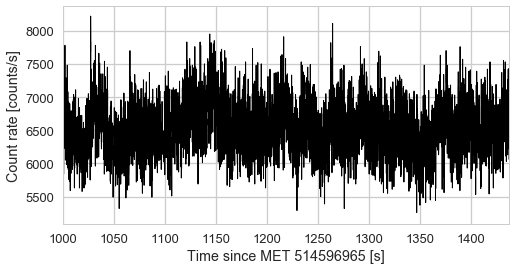

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(lc.time-lc.time[0], lc.countrate, lw=1, color="black", linestyle="steps-mid")
ax.set_xlim(1000, lc.time[-1]-lc.time[0])

ax.set_xlabel("Time since MET %.0f [s]"%lc.time[0])
ax.set_ylabel("Count rate [counts/s]")

In [34]:
lc_rebin = lc.rebin(dt_new=lc.dt*10.0)

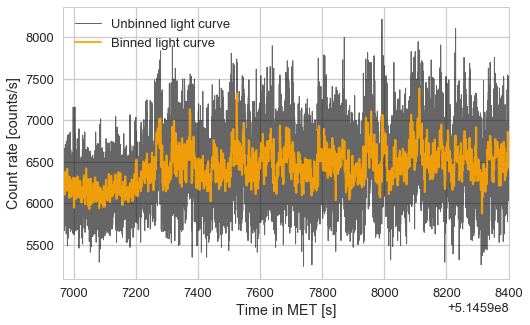

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.plot(lc.time, lc.countrate, lw=1, color="black", linestyle="steps-mid", 
        label="Unbinned light curve", alpha=0.6)
ax.plot(lc_rebin.time, lc_rebin.countrate, lw=2, color="orange", linestyle="steps-mid", 
        label="Binned light curve", alpha=0.9)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Time in MET [s]")
ax.set_ylabel("Count rate [counts/s]")
ax.legend()
fig.savefig("../figures/example_lc.pdf", format="pdf")


Let's save the data to file for the Altair plots:

In [36]:
lc_df = pd.DataFrame({"time":lc.time, "countrate":lc.countrate, "label":["unbinned data"]*len(lc.time)})
lc_df.to_json("gx339_test_lc.json", orient="records")
#lc_df.to_csv("gx339_test_lc.csv", index=False, header=True)

lc_bin_df = pd.DataFrame({"time":lc_rebin.time, "countrate":lc_rebin.countrate, "label":["binned data"]*len(lc_rebin.time)})
lc_bin_df.to_json("gx339_binned_test_lc.json", orient="records")

In [37]:
lc = Lightcurve.make_lightcurve(time, dt=0.03, gti=np.array([gti[0]]))

In [38]:
ps = Powerspectrum(lc, norm="frac")

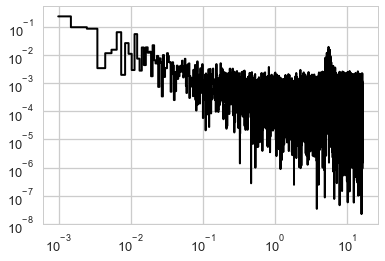

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.loglog(ps.freq, ps.power, ls="steps-mid", lw=2, c="black")

Let's make an averaged periodogram:

In [40]:
# segment size in same time units as light curve object
seg_size = 64.0
# compute averaged power spectrum
avg_ps = AveragedPowerspectrum(lc, seg_size, norm="frac")

In [41]:
avg_ps.df

0.015627441785450308

In [42]:
lc.dt

0.03

In [43]:
avg_ps.m

15

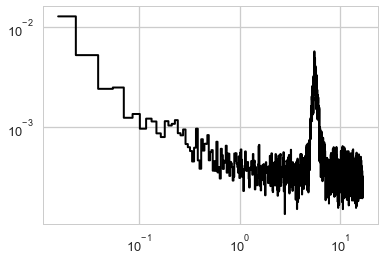

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.loglog(avg_ps.freq, avg_ps.power, ls="steps-mid", lw=2, c="black")

In [45]:
ps.df

0.0009823279206696797

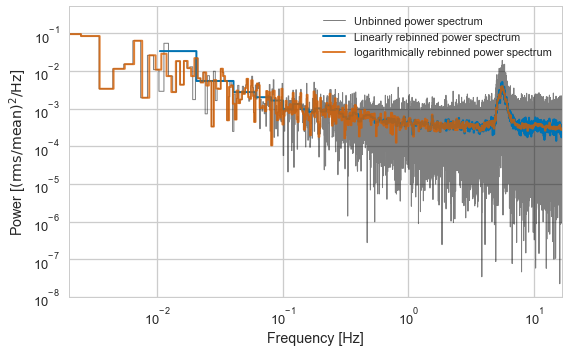

In [46]:
ps_rebin = ps.rebin(df=0.02)
ps_log_rebin = ps.rebin_log()

fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.loglog(ps.freq, ps.power, linestyle="steps-mid", color="black", 
         linewidth=1, alpha=0.5, label="Unbinned power spectrum")
ax.loglog(ps_rebin.freq, ps_rebin.power, linestyle="steps-mid", color=sns.color_palette()[0],
         linewidth=2, alpha=1.0, label="Linearly rebinned power spectrum")
ax.loglog(ps_log_rebin.freq, ps_log_rebin.power, linestyle="steps-mid", color=sns.color_palette()[2],
         linewidth=2, alpha=0.8, label="logarithmically rebinned power spectrum")

ax.set_xlim(ps.freq[1], ps.freq[-1])
#ax.set_ylim(1e-5, 1e4)
ax.legend(loc=1, prop={"size":11})
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
plt.tight_layout()



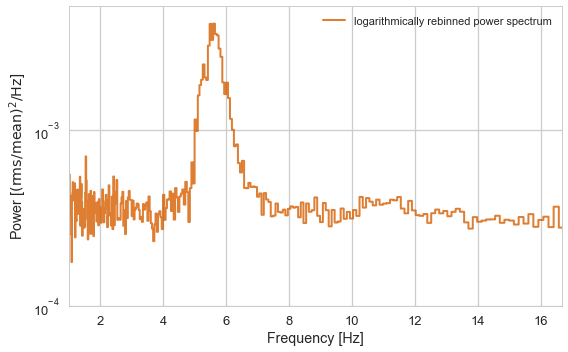

In [47]:
lc_harmonic = Lightcurve.make_lightcurve(time, dt=.5/20.0, gti=np.array([gti[0]]))

ps_harmonic = Powerspectrum(lc_harmonic, norm="frac")

ps_rebin_harmonic = ps_harmonic.rebin(df=0.02)
ps_log_rebin_harmonic = ps_harmonic.rebin_log()

fig, ax = plt.subplots(1, 1, figsize=(8,5))

#ax.loglog(ps.freq, ps.power, linestyle="steps-mid", color="black", 
#         linewidth=1, alpha=0.5, label="Unbinned power spectrum")
#ax.loglog(ps_rebin.freq, ps_rebin.power, linestyle="steps-mid", color=sns.color_palette()[0],
#         linewidth=2, alpha=1.0, label="Linearly rebinned power spectrum")
ax.semilogy(ps_log_rebin_harmonic.freq, ps_log_rebin_harmonic.power, linestyle="steps-mid", color=sns.color_palette()[2],
         linewidth=2, alpha=0.8, label="logarithmically rebinned power spectrum")

ax.set_xlim(1.0, ps.freq[-1])
ax.set_ylim(1e-4, 0.005)
ax.legend(loc=1, prop={"size":11})
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
plt.tight_layout()




Let's save the PSDs for making plots in Altair:

In [48]:
ps_df = pd.DataFrame({"freq":ps.freq, "power":ps.power, "err":ps.power_err, 
                      "pslabel": "unbinned power spectrum"})
ps_bin_df = pd.DataFrame({"freq":ps_rebin.freq, "power":ps_rebin.power, "err":ps_rebin.power_err, 
                          "pslabel": "linearly binned power spectrum"})
ps_log_df = pd.DataFrame({"freq":ps_log_rebin.freq, "power":ps_log_rebin.power, 
                          "err":ps_log_rebin.power_err, "pslabel": "logarithmically binned power spectrum"})

ps_concat_df = pd.concat([ps_df, ps_bin_df, ps_log_df])

In [83]:
ps_df.to_json("gx339_psd.json", orient="records")
ps_bin_df.to_json("gx339_psd_bin.json", orient="records")
ps_log_df.to_json("gx339_psd_logbin.json", orient="records")

ps_concat_df.to_json("gx339_psd_concat.json", orient="records")

Let's make a combined plot with the light curve and the PSD

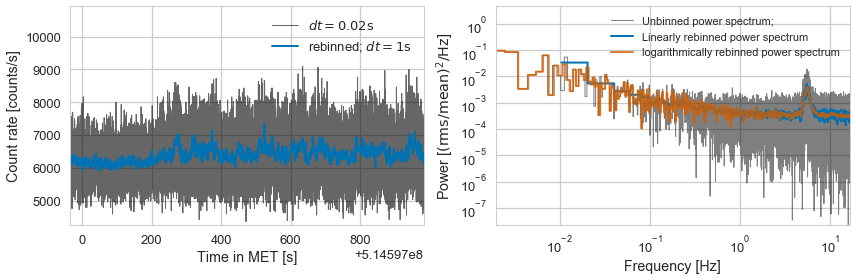

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(lc.time, lc.countrate, lw=1, color="black", linestyle="steps-mid", 
        label=r"$dt = 0.02\mathrm{s}$", alpha=0.6)
ax1.plot(lc_rebin.time, lc_rebin.countrate, lw=2, color=sns.color_palette()[0], linestyle="steps-mid", 
        label="rebinned; $dt=1\mathrm{s}$", alpha=1)

ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_ylim(np.min(lc.countrate)-100, np.max(lc.countrate)*1.2)
ax1.set_xlabel("Time in MET [s]")
ax1.set_ylabel("Count rate [counts/s]")
ax1.legend()

ax2.loglog(ps.freq, ps.power, linestyle="steps-mid", color="black", 
         linewidth=1, alpha=0.5, label="Unbinned power spectrum;")
ax2.loglog(ps_rebin.freq, ps_rebin.power, linestyle="steps-mid", color=sns.color_palette()[0],
         linewidth=2, alpha=1.0, label="Linearly rebinned power spectrum")
ax2.loglog(ps_log_rebin.freq, ps_log_rebin.power, linestyle="steps-mid", color=sns.color_palette()[2],
         linewidth=2, alpha=0.8, label="logarithmically rebinned power spectrum")

ax2.set_xlim(ps.freq[1], ps.freq[-1])
ax2.set_ylim(np.min(ps.power), np.max(ps.power)*20)
ax2.legend(loc=1, prop={"size":11})
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
plt.tight_layout()

plt.savefig("../figures/example_lc_ps.pdf", format="pdf")


### Dynamical Power Spectrum 

Let's create a dynamical power spectrum:

In [85]:
lc_dps = Lightcurve.make_lightcurve(time, dt=0.02, gti=np.array([gti[0]]))

In [86]:
from stingray import DynamicalPowerspectrum

In [87]:
dps = DynamicalPowerspectrum(lc_dps, segment_size=16.0)

In [88]:
dps.dyn_ps.shape

(399, 63)

In [89]:
dps.df

0.06250005960470162

In [90]:
dps.rebin_frequency(0.3, method="mean")

In [91]:
# By looking into the maximum power of each segment
max_pos = dps.trace_maximum(min_freq=3, max_freq=8)

In [92]:
import matplotlib.cm as cm

In [93]:
dps.dyn_ps.shape

(83, 63)

In [94]:
dps.time.shape

(63,)

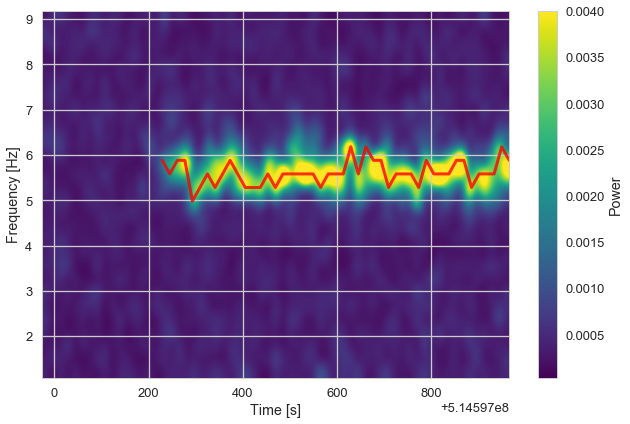

In [95]:
fig, ax = plt.subplots(1,1, figsize=(9,6))

extent = min(dps.time), max(dps.time), dps.freq[3], dps.freq[30]
im = ax.imshow(dps.dyn_ps[3:31,:], aspect="auto", origin="lower", vmax=0.004,
           interpolation="bicubic", extent=extent, cmap=cm.viridis)
ax.plot(dps.time[16:], dps.freq[max_pos][16:], color='red', lw=3, alpha=0.8, zorder=10)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Frequency [Hz]')

fig.colorbar(im, label="Power")
plt.tight_layout()

plt.savefig("../figures/dyn_spec.pdf", format="pdf")

Let's save this to file for plotting in Altair:

In [96]:
dynps_freq = dps.freq[3:31]
dynps_time = dps.time

In [97]:
x, y = np.meshgrid(dynps_time,dynps_freq)

In [98]:
dynps = dps.dyn_ps[3:31,:]


dynps_time = x.ravel()
dynps_freq = y.ravel()


In [102]:
dynps = dynps.ravel()

In [103]:
dynps_df = pd.DataFrame({"time":dynps_time, "freq":dynps_freq, "dynps":dynps})

In [104]:
maxpos_df = pd.DataFrame({"time": dps.time[15:]+8.0, "maxfreq": dps.freq[max_pos][15:]})

In [105]:
dynps_df.to_json("gx339_dynps.json", orient="records")
maxpos_df.to_json("gx339_dynps_maxpos.json", orient="records")

## Parametric Modeling

In [106]:
from stingray.modeling import PSDPosterior, PSDParEst, PSDLogLikelihood

In [107]:
from astropy.modeling import models

In [108]:
m = models.m = models.PowerLaw1D() + models.Lorentz1D()
m_new = m + models.Const1D()
m_new.x_0_0.fixed = True

In [109]:
ps.m

1

In [110]:
loglike = PSDLogLikelihood(ps.freq, ps.power, m_new, m=ps.m)

In [111]:
start_pars = [0.0005, 1.3, 4, 6, 0.5, np.mean(ps.power[-50:])]

In [112]:
parest = PSDParEst(ps, fitmethod='powell', max_post=False)

In [113]:
res = parest.fit(loglike, start_pars)

In [114]:
res.p_opt

array([ 4.31755881e-05,  1.30101293e+00, -3.23415558e-03,  5.46282374e+05,
        3.24359916e+08,  3.73034273e-03])

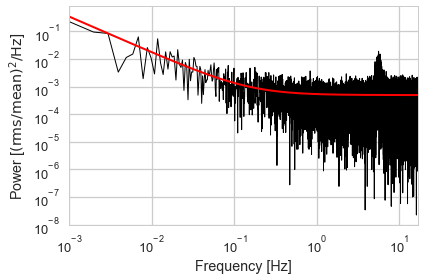

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.loglog(ps.freq, ps.power, 
            markersize=3, linewidth=1, color="black")
ax.plot(ps.freq, res.mfit, lw=2, color="red")
#ax.plot(freq, spec, color="purple")
ax.set_xlim(ps.freq[0], ps.freq[-1])
ax.set_xscale('log')
ax.set_yscale("log")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
plt.tight_layout()

In [116]:
start_pars = [0.001, 1, 0.1, 6, 0.5, np.mean(ps.power[-50:])]

In [117]:
aps_parest = PSDParEst(avg_ps, fitmethod='BFGS', max_post=False)
aps_loglike = PSDLogLikelihood(avg_ps.freq, avg_ps.power, m_new, m=avg_ps.m)

aps_res = aps_parest.fit(aps_loglike, start_pars)

In [118]:
test_m = m_new(avg_ps.freq)

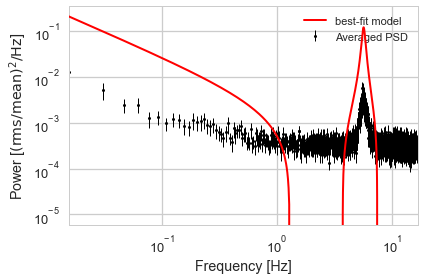

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.errorbar(avg_ps.freq, avg_ps.power, yerr=avg_ps.power_err, fmt="o",
            markersize=3, linewidth=1, color="black", 
            label="Averaged PSD")
ax.plot(avg_ps.freq, test_m, lw=2, color="red", zorder=10,
        label="best-fit model")
ax.set_xlim(avg_ps.freq[0], avg_ps.freq[-1])
ax.set_xscale('log')
ax.set_yscale("log")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
ax.legend(loc=1, prop={"size":11})
plt.tight_layout()

In [120]:
import scipy.stats

In [121]:
p_amplitude_0 = lambda amplitude: scipy.stats.uniform(loc=-20, scale=40).pdf(np.log(amplitude))
p_amplitude_1 = lambda amplitude: scipy.stats.uniform(loc=-20, scale=40).pdf(np.log(amplitude))
p_amplitude_2 = lambda amplitude: scipy.stats.uniform(loc=-20, scale=40).pdf(np.log(amplitude))

p_alpha_0 = lambda alpha: scipy.stats.uniform(loc=0, scale=5).pdf(alpha)

p_x_0_1 = lambda x_0_1: scipy.stats.uniform(loc=0.0039, scale=0.0039+9.998).pdf(x_0_1)
p_fwhm_1 = lambda fwhm: scipy.stats.uniform(loc=np.log(0.01), scale=np.log(10.0)-np.log(0.01)).pdf(np.log(fwhm))

In [122]:
prior_dict = {"amplitude_0":p_amplitude_0, "amplitude_1":p_amplitude_1,
              "amplitude_2":p_amplitude_2, "alpha_0": p_alpha_0,
              "x_0_1": p_x_0_1, "fwhm_1":p_fwhm_1}

In [123]:
lpost = PSDPosterior(avg_ps.freq, avg_ps.power, m_new, priors=prior_dict, m=avg_ps.m)

In [124]:
aps_parest = PSDParEst(avg_ps, max_post=True, fitmethod="powell")

In [125]:
aps_res = aps_parest.fit(lpost, start_pars, neg=True)

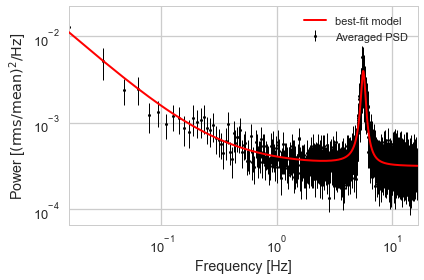

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.errorbar(avg_ps.freq, avg_ps.power, yerr=avg_ps.power_err, fmt="o",
            markersize=3, linewidth=1, color="black", 
            label="Averaged PSD")
ax.plot(avg_ps.freq, aps_res.mfit, lw=2, color="red", zorder=10,
        label="best-fit model")
ax.set_xlim(avg_ps.freq[0], avg_ps.freq[-1])
ax.set_xscale('log')
ax.set_yscale("log")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
ax.legend(loc=1, prop={"size":11})
plt.tight_layout()

In [127]:
sample = aps_parest.sample(lpost, aps_res.p_opt, cov=aps_res.cov,
                           nwalkers=200, burnin=100, niter=100, threads=1 )

/Users/danielahuppenkothen/work/sw/miniconda3/lib/python3.6/site-packages/stingray-0.1rc1-py3.6.egg/stingray/modeling/parameterestimation.py:629: RuntimeWarning: covariance is not positive-semidefinite.
  i in range(nwalkers)])
-- The acceptance fraction is: 0.518800.5
INFO:MCMC summary:-- The acceptance fraction is: 0.518800.5
R_hat for the parameters is: [4.45868939e-11 1.42455099e-03 2.99848796e-08 4.74497212e-05
 2.57065663e-04 7.20037741e-12]
INFO:MCMC summary:R_hat for the parameters is: [4.45868939e-11 1.42455099e-03 2.99848796e-08 4.74497212e-05
 2.57065663e-04 7.20037741e-12]
-- Posterior Summary of Parameters: 

INFO:MCMC summary:-- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

INFO:MCMC summary:parameter 	 mean 		 sd 		 5% 		 95% 

---------------------------------------------

INFO:MCMC summary:---------------------------------------------

theta[0] 	 8.612901922324455e-05	6.689386509895657e-06	7.496659482909001e-05	9.686716605521811e-05

INFO:MCM

In [128]:
import corner

In [129]:
samples = sample.samples

In [130]:
#samples[:,0] = np.exp(samples[:,0])
#samples[:,-1] = np.exp(samples[:,-1])

In [131]:
from astropy.modeling.fitting import _fitter_to_model_params

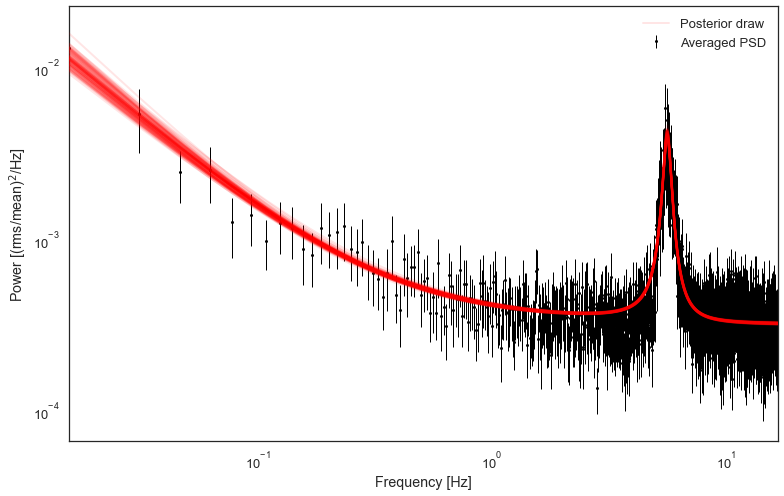

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(11,7))

ax.errorbar(avg_ps.freq, avg_ps.power, yerr=avg_ps.power_err, fmt="o",
            markersize=3, linewidth=1, color="black", 
            label="Averaged PSD")

#ax.plot(avg_ps.freq, aps_res.mfit, lw=2, color="blue", alpha=1.0, label="MAP Estimate")

ax.set_xlim(avg_ps.freq[0], avg_ps.freq[-1])
ax.set_xscale("log")
ax.set_yscale('log')
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Power [(rms/mean)$^2$/Hz]")

idx = np.random.choice(np.arange(samples.shape[0], dtype=int), replace=False, size=100)

m_all = []
for i, x in enumerate(idx):
    s = samples[x]
    _fitter_to_model_params(m_new, s)
    ms = m_new(avg_ps.freq)
    m_all.append(pd.DataFrame({"freq":avg_ps.freq, "power":ms, "idx":i}))
    
    if i == 0:
        ax.plot(avg_ps.freq, ms, lw=2, c="red", alpha=0.1, label="Posterior draw")
    else:
        ax.plot(avg_ps.freq, ms, lw=2, c="red", alpha=0.1, zorder=10)
    
ax.legend()
plt.tight_layout()
plt.savefig("../figures/example_posterior.pdf", format='pdf')

In [160]:
avg_ps_df = pd.DataFrame({"freq":avg_ps.freq, "power":avg_ps.power, 
                          "err":avg_ps.power_err, "label":"observed PSD"})
avg_ps_df.to_json("gx339_avg_ps.json", orient="records")

In [161]:
all_models = pd.concat(m_all)

In [162]:
all_models["label"] = "posterior samples"

In [163]:
all_models.to_json("gx339_avg_ps_models.json", orient="records")

Let's make a corner plot:

In [133]:
import corner

In [134]:
labels = [r"$A_\mathrm{PL}$", r"$\alpha$", r"$A_\mathrm{QPO}$", r"$\nu_0$", r"$\Delta_\nu$", r"$A_\mathrm{WN}$"]

In [135]:
sns.set_style("white")

In [139]:
samples.shape

(20000, 6)

In [140]:
sample_df = pd.DataFrame({"apl":samples[:,0], "alpha":samples[:,1], "aqpo":samples[:,2],
              "nu0":samples[:,3], "deltanu":samples[:,4], "awn":samples[:,5]})


In [141]:
sample_df.to_json("gx339_samples.json", orient="records")

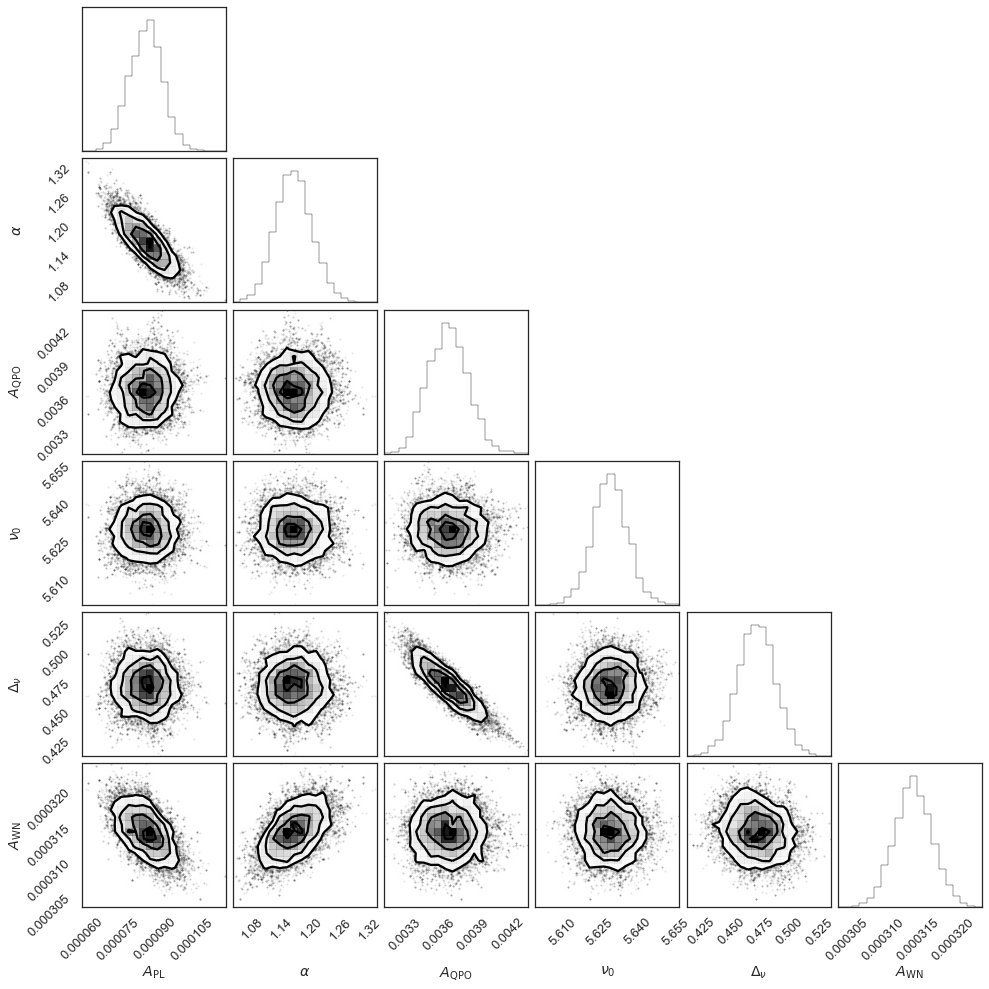

In [136]:
labels = [r"$A_\mathrm{PL}$", r"$\alpha$", r"$A_\mathrm{QPO}$", r"$\nu_0$", r"$\Delta_\nu$", r"$A_\mathrm{WN}$"]
fig = corner.corner(samples, labels=labels,
                    labelpad=0.1)

#axes = np.array(fig.axes).reshape((3, 3))

plt.savefig("../figures/example_psd_corner.pdf", format="pdf")


## Covariance Spectrum

We first need to set up an Events object

In [ ]:
from stingray.events import EventList

In [ ]:
time_idx = time.argsort()

In [ ]:
time_sorted = time[time_idx]
energies_sorted = energies[time_idx]
channel_sorted = channel[time_idx]

In [ ]:
evt = EventList(time=time_sorted, energy=energies_sorted, gti=gti)

In [ ]:
from stingray import AveragedCovariancespectrum

In [ ]:
covspec = AveragedCovariancespectrum(evt, dt=0.1, segment_size=8.0)

In [ ]:
eg = np.sort(np.unique(evt.energy))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.errorbar(eg, covspec.covar, yerr=covspec.covar_error, fmt="o",  color="black", markersize=5)
#ax.semilogy(eg, covspec.covar, linestyle="--", color="black", linewidth=1, alpha=0.4)

ax.set_xlim(0,10)
ax.set_xlabel("Energy [keV]")
ax.set_ylabel("normalized counts $\mathrm{s}^{-1}$ $\mathrm{keV}^{-1}$")
ax.set_yscale("log")

plt.savefig("../figures/covspec.pdf", format="pdf")

## Bispectrum and Biphase

In [ ]:
from stingray import Bispectrum

In [ ]:
dt =  0.5/20.0
lc = Lightcurve.make_lightcurve(time, dt, gti=[gti[0]])

In [ ]:
tseg = 8.0
lcshort_n = int(tseg/dt)
print(lcshort_n)

In [ ]:
nstart = 0
nend = lcshort_n

bs_all = []

while nend <= lc.n:
    lcshort = lc.truncate(start=nstart, stop=nend, method="index")
    bs_short = Bispectrum(lcshort, maxlag=100, scale="biased")
    bs_all.append(bs_short)
    
    nstart += lcshort_n
    nend += lcshort_n

In [ ]:
len(bs_all)

In [ ]:
bispec_mag_all, bispec_phase_all = [], []

for bs in bs_all:
    bispec_mag_all.append(bs.bispec_mag)
    bispec_phase_all.append(np.abs(bs.bispec_phase)**2.)
    
bispec_mag_all = np.array(bispec_mag_all)
bispec_phase_all = np.array(bispec_phase_all)

In [ ]:
bispec_mag_all.shape

In [ ]:
bispec_mag_mean = np.mean(bispec_mag_all, axis=0)
bispec_phase_mean = np.mean(bispec_phase_all, axis=0)

In [ ]:
sns.set_style("white")

fig, ax = plt.subplots(1, 1, figsize=(15,15))

nfreq = len(bs_all[0].freq)
s_freq = int(nfreq/2)

extent = 0, np.max(bs_all[0].freq), 0, np.max(bs_all[0].freq)
im = ax.imshow(bispec_mag_mean[:s_freq, s_freq:], cmap=cm.viridis, extent=extent,
               interpolation="bicubic", vmax=200000)
fig.colorbar(im)
#ax.set_xscale("log")
#ax.set_yscale('log')

In [ ]:
sns.set_style("white")

fig, ax = plt.subplots(1, 1, figsize=(15,15))

nfreq = len(bs_all[0].freq)
s_freq = int(nfreq/2)

extent = 0, np.max(bs_all[0].freq), 0, np.max(bs_all[0].freq)
im = ax.imshow(bispec_phase_mean[:s_freq, s_freq:], cmap=cm.viridis, extent=extent,
               interpolation="bicubic", vmin=3.5, vmax=4.4)
fig.colorbar(im)
#ax.set_xscale("log")
#ax.set_yscale('log')

In [ ]:
bs = Bispectrum(lc, maxlag=100, scale="unbiased")

In [ ]:
bs.bispec.shape

In [ ]:
bs.bispec_phase.shape

In [ ]:
sns.set_style("white")

fig, ax = plt.subplots(1, 1, figsize=(6,6))

extent = np.min(bs.freq), np.max(bs.freq), np.min(bs.freq), np.max(bs.freq)
im = ax.imshow(bs.bispec_mag, cmap=cm.viridis, extent=extent,
               interpolation="none", vmax=30)
fig.colorbar(im)

In [ ]:
sns.set_style("white")

fig, ax = plt.subplots(1, 1, figsize=(6,6))

extent = 0, np.max(bs.freq), 0, np.max(bs.freq)
im = ax.imshow(bs.bispec_mag[:int(len(bs.freq)/2), int(len(bs.freq)/2):], cmap=cm.viridis, extent=extent,
               interpolation="bicubic", vmax=25)
fig.colorbar(im)


In [ ]:
p = bs.plot_cum3()
p.show()

In [ ]:
p = bs.plot_mag()
p.show()

In [ ]:
p = bs.plot_phase()
p.show()

Some fun tests with the Bispectrum:

## Variability-Energy Spectrum

Let's do a variability-energy spectrum for fun

## Lag-Energy Spectrum

Let's do a lag-energy spectrum

## Time Lags

Let's try to calculate some time lags.